The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.5


# Linear Regression
:label:`sec_linear_regression`

*Regression* refers to a set of methods for modeling
the relationship between one or more independent variables
and a dependent variable.
In the natural sciences and social sciences,
the purpose of regression is most often to
*characterize* the relationship between the inputs and outputs.
Machine learning, on the other hand,
is most often concerned with *prediction*.

Regression problems pop up whenever we want to predict a numerical value.
Common examples include predicting prices (of homes, stocks, etc.),
predicting length of stay (for patients in the hospital),
demand forecasting (for retail sales), among countless others.
Not every prediction problem is a classic regression problem.
In subsequent sections, we will introduce classification problems,
where the goal is to predict membership among a set of categories.


## Basic Elements of Linear Regression

*Linear regression* may be both the simplest
and most popular among the standard tools to regression.
Dating back to the dawn of the 19th century,
linear regression flows from a few simple assumptions.
First, we assume that the relationship between
the independent variables $\mathbf{x}$ and the dependent variable $y$ is linear,
i.e., that $y$ can be expressed as a weighted sum
of the elements in $\mathbf{x}$,
given some noise on the observations.
Second, we assume that any noise is well-behaved
(following a Gaussian distribution).

To motivate the approach, let us start with a running example.
Suppose that we wish to estimate the prices of houses (in dollars)
based on their area (in square feet) and age (in years).
To actually develop a model for predicting house prices,
we would need to get our hands on a dataset
consisting of sales for which we know
the sale price, area, and age for each home.
In the terminology of machine learning,
the dataset is called a *training dataset* or *training set*,
and each row (here the data corresponding to one sale)
is called an *example* (or *data point*, *data instance*, *sample*).
The thing we are trying to predict (price)
is called a *label* (or *target*).
The independent variables (age and area)
upon which the predictions are based
are called *features* (or *covariates*).

Typically, we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


### Linear Model
:label:`subsec_linear_model`

The linearity assumption just says that the target (price)
can be expressed as a weighted sum of the features (area and age):

$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$
:eqlabel:`eq_price-area`

In :eqref:`eq_price-area`, $w_{\mathrm{area}}$ and $w_{\mathrm{age}}$
are called *weights*, and $b$ is called a *bias*
(also called an *offset* or *intercept*).
The weights determine the influence of each feature
on our prediction and the bias just says
what value the predicted price should take
when all of the features take value 0.
Even if we will never see any homes with zero area,
or that are precisely zero years old,
we still need the bias or else we will
limit the expressivity of our model.
Strictly speaking, :eqref:`eq_price-area` is an *affine transformation*
of input features,
which is characterized by
a *linear transformation* of features via weighted sum, combined with
a *translation* via the added bias.

Given a dataset, our goal is to choose
the weights $\mathbf{w}$ and the bias $b$ such that on average,
the predictions made according to our model
best fit the true prices observed in the data.
Models whose output prediction
is determined by the affine transformation of input features
are *linear models*,
where the affine transformation is specified by the chosen weights and bias.


In disciplines where it is common to focus
on datasets with just a few features,
explicitly expressing models long-form like this is common.
In machine learning, we usually work with high-dimensional datasets,
so it is more convenient to employ linear algebra notation.
When our inputs consist of $d$ features,
we express our prediction $\hat{y}$ (in general the "hat" symbol denotes estimates) as

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly using a dot product:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

In :eqref:`eq_linreg-y`, the vector $\mathbf{x}$ corresponds to features of a single data example.
We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$

where broadcasting (see :numref:`subsec_broadcasting`) is applied during the summation.
Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
that given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation) be predicted with the lowest error.


Even if we believe that the best model for
predicting $y$ given $\mathbf{x}$ is linear,
we would not expect to find a real-world dataset of $n$ examples where
$y^{(i)}$ exactly equals $\mathbf{w}^\top \mathbf{x}^{(i)}+b$
for all $1 \leq i \leq n$.
For example, whatever instruments we use to observe
the features $\mathbf{X}$ and labels $\mathbf{y}$
might suffer small amount of measurement error.
Thus, even when we are confident
that the underlying relationship is linear,
we will incorporate a noise term to account for such errors.

Before we can go about searching for the best *parameters* (or *model parameters*) $\mathbf{w}$ and $b$,
we will need two more things:
(i) a quality measure for some given model;
and (ii) a procedure for updating the model to improve its quality.


### Loss Function

Before we start thinking about how to *fit* data with our model,
we need to determine a measure of *fitness*.
The *loss function* quantifies the distance
between the *real* and *predicted* value of the target.
The loss will usually be a non-negative number
where smaller values are better
and perfect predictions incur a loss of 0.
The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

The constant $\frac{1}{2}$ makes no real difference
but will prove notationally convenient,
canceling out when we take the derivative of the loss.
Since the training dataset is given to us, and thus out of our control,
the empirical error is only a function of the model parameters.
To make things more concrete, consider the example below
where we plot a regression problem for a one-dimensional case
as shown in :numref:`fig_fit_linreg`.

![Fit data with a linear model.](../img/fit-linreg.svg)
:label:`fig_fit_linreg`

Note that large differences between
estimates $\hat{y}^{(i)}$ and observations $y^{(i)}$
lead to even larger contributions to the loss,
due to the quadratic dependence.
To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


### Analytic Solution

Linear regression happens to be an unusually simple optimization problem.
Unlike most other models that we will encounter in this book,
linear regression can be solved analytically by applying a simple formula.
To start, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all ones.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
There is just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields the analytic (closed-form) solution:

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}.$$

While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude all of deep learning.


### Minibatch Stochastic Gradient Descent

Even in cases where we cannot solve the models analytically,
it turns out that we can still train models effectively in practice.
Moreover, for many tasks, those difficult-to-optimize models
turn out to be so much better that figuring out how to train them
ends up being well worth the trouble.

The key technique for optimizing nearly any deep learning model,
and which we will call upon throughout this book,
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function.
This algorithm is called *gradient descent*.

The most naive application of gradient descent
consists of taking the derivative of the loss function,
which is an average of the losses computed
on every single example in the dataset.
In practice, this can be extremely slow:
we must pass over the entire dataset before making a single update.
Thus, we will often settle for sampling a random minibatch of examples
every time we need to compute the update,
a variant called *minibatch stochastic gradient descent*.

In each iteration, we first randomly sample a minibatch $\mathcal{B}$
consisting of a fixed number of training examples.
We then compute the derivative (gradient) of the average loss
on the minibatch with regard to the model parameters.
Finally, we multiply the gradient by a predetermined positive value $\eta$
and subtract the resulting term from the current parameter values.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


To summarize, steps of the algorithm are the following:
(i) we initialize the values of the model parameters, typically at random;
(ii) we iteratively sample random minibatches from the data,
updating the parameters in the direction of the negative gradient.
For quadratic losses and affine transformations,
we can write this out explicitly as follows:

$$\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`


Note that $\mathbf{w}$ and $\mathbf{x}$ are vectors in :eqref:`eq_linreg_batch_update`.
Here, the more elegant vector notation makes the math
much more readable than expressing things in terms of coefficients,
say $w_1, w_2, \ldots, w_d$.
The set cardinality
$|\mathcal{B}|$ represents
the number of examples in each minibatch (the *batch size*)
and $\eta$ denotes the *learning rate*.
We emphasize that the values of the batch size and learning rate
are manually pre-specified and not typically learned through model training.
These parameters that are tunable but not updated
in the training loop are called *hyperparameters*.
*Hyperparameter tuning* is the process by which hyperparameters are chosen,
and typically requires that we adjust them
based on the results of the training loop
as assessed on a separate *validation dataset* (or *validation set*).

After training for some predetermined number of iterations
(or until some other stopping criteria are met),
we record the estimated model parameters,
denoted $\hat{\mathbf{w}}, \hat{b}$.
Note that even if our function is truly linear and noiseless,
these parameters will not be the exact minimizers of the loss
because, although the algorithm converges slowly towards the minimizers
it cannot achieve it exactly in a finite number of steps.

Linear regression happens to be a learning problem where there is only one minimum
over the entire domain.
However, for more complicated models, like deep networks,
the loss surfaces contain many minima.
Fortunately, for reasons that are not yet fully understood,
deep learning practitioners seldom struggle to find parameters
that minimize the loss *on training sets*.
The more formidable task is to find parameters
that will achieve low loss on data
that we have not seen before,
a challenge called *generalization*.
We return to these topics throughout the book.


### Making Predictions with the Learned Model


Given the learned linear regression model
$\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$,
we can now estimate the price of a new house
(not contained in the training data)
given its area $x_1$ and age $x_2$.
Estimating targets given features is
commonly called *prediction* or *inference*.

We will try to stick with *prediction* because
calling this step *inference*,
despite emerging as standard jargon in deep learning,
is somewhat of a misnomer.
In statistics, *inference* more often denotes
estimating parameters based on a dataset.
This misuse of terminology is a common source of confusion
when deep learning practitioners talk to statisticians.


## Vectorization for Speed

When training our models, we typically want to process
whole minibatches of examples simultaneously.
Doing this efficiently requires that (**we**) (~~should~~) (**vectorize the calculations
and leverage fast linear algebra libraries
rather than writing costly for-loops in Python.**)


In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

To illustrate why this matters so much,
we can (**consider two methods for adding vectors.**)
To start we instantiate two 10000-dimensional vectors
containing all ones.
In one method we will loop over the vectors with a Python for-loop.
In the other method we will rely on a single call to `+`.


In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

Since we will benchmark the running time frequently in this book,
[**let us define a timer**].


In [3]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

Now we can benchmark the workloads.
First, [**we add them, one coordinate at a time,
using a for-loop.**]


In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.10930 sec'

(**Alternatively, we rely on the reloaded `+` operator to compute the elementwise sum.**)


In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00037 sec'

You probably noticed that the second method
is dramatically faster than the first.
Vectorizing code often yields order-of-magnitude speedups.
Moreover, we push more of the mathematics to the library
and need not write as many calculations ourselves,
reducing the potential for errors.

## The Normal Distribution and Squared Loss
:label:`subsec_normal_distribution_and_squared_loss`

While you can already get your hands dirty using only the information above,
in the following we can more formally motivate the squared loss objective
via assumptions about the distribution of noise.

Linear regression was invented by Gauss in 1795,
who also discovered the normal distribution (also called the *Gaussian*).
It turns out that the connection between
the normal distribution and linear regression
runs deeper than common parentage.
To refresh your memory, the probability density
of a normal distribution with mean $\mu$ and variance $\sigma^2$ (standard deviation $\sigma$)
is given as

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

Below [**we define a Python function to compute the normal distribution**].


In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

We can now (**visualize the normal distributions**).


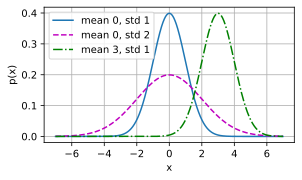

In [7]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

As we can see, changing the mean corresponds to a shift along the $x$-axis,
and increasing the variance spreads the distribution out, lowering its peak.

One way to motivate linear regression with the mean squared error loss function (or simply squared loss)
is to formally assume that observations arise from noisy observations,
where the noise is normally distributed as follows:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

Now, according to the principle of maximum likelihood,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).$$

Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the log of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything we can minimize the *negative log-likelihood*
$-\log P(\mathbf y \mid \mathbf X)$.
Working out the mathematics gives us:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

Now we just need one more assumption that $\sigma$ is some fixed constant.
Thus we can ignore the first term because
it does not depend on $\mathbf{w}$ or $b$.
Now the second term is identical to the squared error loss introduced earlier,
except for the multiplicative constant $\frac{1}{\sigma^2}$.
Fortunately, the solution does not depend on $\sigma$.
It follows that minimizing the mean squared error
is equivalent to maximum likelihood estimation
of a linear model under the assumption of additive Gaussian noise.

## From Linear Regression to Deep Networks

So far we only talked about linear models.
While neural networks cover a much richer family of models,
we can begin thinking of the linear model
as a neural network by expressing it in the language of neural networks.
To begin, let us start by rewriting things in a "layer" notation.

### Neural Network Diagram

Deep learning practitioners like to draw diagrams
to visualize what is happening in their models.
In :numref:`fig_single_neuron`,
we depict our linear regression model as a neural network.
Note that these diagrams highlight the connectivity pattern
such as how each input is connected to the output,
but not the values taken by the weights or biases.

![Linear regression is a single-layer neural network.](http://d2l.ai/_images/singleneuron.svg)
:label:`fig_single_neuron`

For the neural network shown in :numref:`fig_single_neuron`,
the inputs are $x_1, \ldots, x_d$,
so the *number of inputs* (or *feature dimensionality*) in the input layer is $d$.
The output of the network in :numref:`fig_single_neuron` is $o_1$,
so the *number of outputs* in the output layer is 1.
Note that the input values are all *given*
and there is just a single *computed* neuron.
Focusing on where computation takes place,
conventionally we do not consider the input layer when counting layers.
That is to say,
the *number of layers* for the neural network in :numref:`fig_single_neuron` is 1.
We can think of linear regression models as neural networks
consisting of just a single artificial neuron,
or as single-layer neural networks.

Since for linear regression, every input is connected
to every output (in this case there is only one output),
we can regard this transformation (the output layer in :numref:`fig_single_neuron`)
as a *fully-connected layer* or *dense layer*.
We will talk a lot more about networks composed of such layers
in the next chapter.


### Biology

Since linear regression (invented in 1795)
predates computational neuroscience,
it might seem anachronistic to describe
linear regression as a neural network.
To see why linear models were a natural place to begin
when the cyberneticists/neurophysiologists
Warren McCulloch and Walter Pitts began to develop
models of artificial neurons,
consider the cartoonish picture
of a biological neuron in :numref:`fig_Neuron`, consisting of
*dendrites* (input terminals),
the *nucleus* (CPU), the *axon* (output wire),
and the *axon terminals* (output terminals),
enabling connections to other neurons via *synapses*.

![The real neuron.](http://d2l.ai/_images/neuron.svg)
:label:`fig_Neuron`

Information $x_i$ arriving from other neurons
(or environmental sensors such as the retina)
is received in the dendrites.
In particular, that information is weighted by *synaptic weights* $w_i$
determining the effect of the inputs
(e.g., activation or inhibition via the product $x_i w_i$).
The weighted inputs arriving from multiple sources
are aggregated in the nucleus as a weighted sum $y = \sum_i x_i w_i + b$,
and this information is then sent for further processing in the axon $y$,
typically after some nonlinear processing via $\sigma(y)$.
From there it either reaches its destination (e.g., a muscle)
or is fed into another neuron via its dendrites.

Certainly, the high-level idea that many such units
could be cobbled together with the right connectivity
and right learning algorithm,
to produce far more interesting and complex behavior
than any one neuron alone could express
owes to our study of real biological neural systems.

At the same time, most research in deep learning today
draws little direct inspiration in neuroscience.
We invoke Stuart Russell and Peter Norvig who,
in their classic AI text book
*Artificial Intelligence: A Modern Approach* :cite:`Russell.Norvig.2016`,
pointed out that although airplanes might have been *inspired* by birds,
ornithology has not been the primary driver
of aeronautics innovation for some centuries.
Likewise, inspiration in deep learning these days
comes in equal or greater measure from mathematics,
statistics, and computer science.

## Summary

* Key ingredients in a machine learning model are training data, a loss function, an optimization algorithm, and quite obviously, the model itself.
* Vectorizing makes everything better (mostly math) and faster (mostly code).
* Minimizing an objective function and performing maximum likelihood estimation can mean the same thing.
* Linear regression models are neural networks, too.


## Exercises

1. Assume that we have some data $x_1, \ldots, x_n \in \mathbb{R}$. Our goal is to find a constant $b$ such that $\sum_i (x_i - b)^2$ is minimized.
    1. Find a analytic solution for the optimal value of $b$.
    1. How does this problem and its solution relate to the normal distribution?
1. Derive the analytic solution to the optimization problem for linear regression with squared error. To keep things simple, you can omit the bias $b$ from the problem (we can do this in principled fashion by adding one column to $\mathbf X$ consisting of all ones).
    1. Write out the optimization problem in matrix and vector notation (treat all the data as a single matrix, and all the target values as a single vector).
    1. Compute the gradient of the loss with respect to $w$.
    1. Find the analytic solution by setting the gradient equal to zero and solving the matrix equation.
    1. When might this be better than using stochastic gradient descent? When might this method break?
1. Assume that the noise model governing the additive noise $\epsilon$ is the exponential distribution. That is, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.
    1. Write out the negative log-likelihood of the data under the model $-\log P(\mathbf y \mid \mathbf X)$.
    1. Can you find a closed form solution?
    1. Suggest a stochastic gradient descent algorithm to solve this problem. What could possibly go wrong (hint: what happens near the stationary point as we keep on updating the parameters)? Can you fix this?


[Discussions](https://discuss.d2l.ai/t/258)
